# Relax Inc. Challenge


Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period, 
<br>**identify which factors predict future user adoption.**

<br>We suggest spending 1 to 2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no
more than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [77]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt 

# Import data
 - **"takehome_users"** : A user table with data on 12,000 users who signed up for the product in the last two years.
 - **"takehome_user_engagement"** : A usage summary table that has a row for each day that a user logged into the product.

In [78]:
# User table with data on 12,000 users who signed up for the product in the last two years.
df_user = pd.read_csv('/Users/sandidge/Desktop/Python_Projects/Springboard_coursework/RelaxInc_takehome/takehome_users.csv', parse_dates=['creation_time', 'last_session_creation_time'], encoding = "cp1252")

# Usage summary table that has a row for each day that a user logged into the product.
df_engage = pd.read_csv('/Users/sandidge/Desktop/Python_Projects/Springboard_coursework/RelaxInc_takehome/takehome_user_engagement.csv', parse_dates=['time_stamp'])



In [79]:
# there is an issue with takehome_users, check encoding
with open("takehome_users.csv") as f:
    print(f.encoding)

UTF-8


# Exploratory Data Analysis

## Engagement data: takehome_user_engagement.csv

In [80]:
df_engage.info()
df_engage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [81]:
df_engage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


### Engagement over time

In [82]:
print(df_engage.time_stamp.min())
print(df_engage.time_stamp.max())

2012-05-31 08:20:06
2014-06-06 14:58:50


In [83]:
#convert timestamps to dates
df_engage['date'] = df_engage['time_stamp'].dt.date

# Table of users each day
daily_users = df_engage.groupby(['date'])['user_id'].count().to_frame().reset_index()


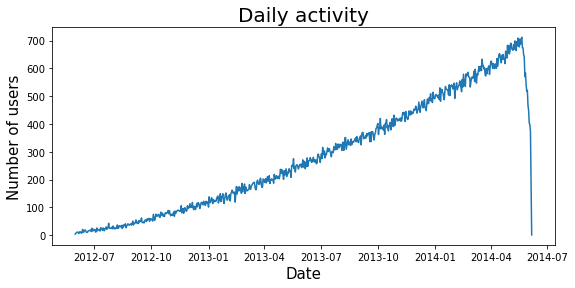

In [84]:
# Look at number of users each day
plt.rcParams["figure.figsize"] = (9,4)

plt.plot(daily_users['date'], daily_users['user_id'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.title('Daily activity', fontsize = 20)

plt.show()



### Visits by each user

In [85]:
# Count user visits
user_visits = df_engage.groupby(['user_id'])['visited'].sum().to_frame().reset_index().sort_values(by='visited', ascending = False)
user_visits


,user_id,visited
2652,3623,606
657,906,600
1315,1811,593
5548,7590,590
5877,8068,585
...,...,...
3440,4699,1
3439,4698,1
3438,4697,1
3437,4696,1


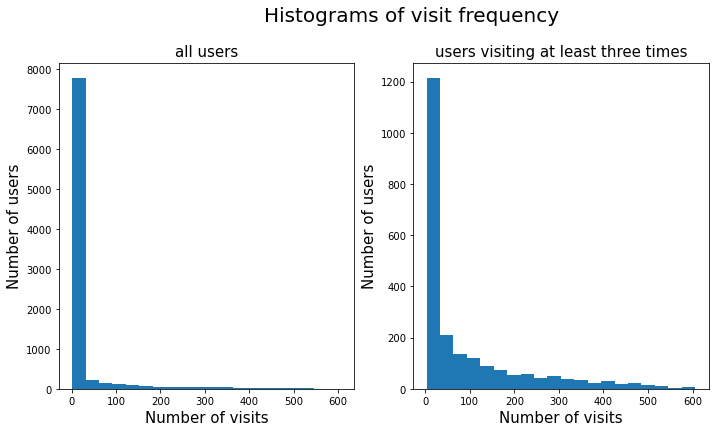

In [86]:
#set figure size
plt.figure(figsize=(18, 6))

# Histogram of number of visits by individual users
plt.subplot(131)
plt.hist(user_visits['visited'], bins = 20)
plt.xlabel('Number of visits', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.title('all users', fontsize = 15)

plt.subplot(132)
plt.hist((user_visits[user_visits['visited']>2])['visited'], bins = 20)
plt.xlabel('Number of visits', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.title('users visiting at least three times', fontsize = 15)

plt.suptitle('Histograms of visit frequency ', fontsize = 20, x=.4, y=1.01)
plt.show()


In [87]:
# Table of frequency of numbers of total visits
visit_freq = user_visits.groupby(['visited'])['visited'].count().to_frame()\
             .rename(columns={'visited': 'users'}).reset_index().rename(columns={'visited': 'visits'})
visit_freq.head(10)

,visits,users
0,1,6235
1,2,340
2,3,241
3,4,181
4,5,110
5,6,85
6,7,68
7,8,57
8,9,48
9,10,34


In [88]:
unique_list = df_engage['user_id'].unique()
unique_users = len(df_engage['user_id'].unique())
print('There are ', unique_users, ' unique users in the dataset')

#range_list = list(range(1,12000))
range_set = set(range(1,12000))
#range_list                  

# prints the missing and additional elements in list2 
missing = len((range_set.difference(set(unique_list))))
print("Number of missing ids (never logged on):", missing)


There are  8823  unique users in the dataset
Number of missing ids (never logged on): 3177


In [89]:
print("{:.1%}".format(missing/12000)+" percent of users never logged in")
print("{:.1%}".format(6235/12000)+" percent of users logged in once")


26.5% percent of users never logged in
52.0% percent of users logged in once


### Define adopted users

In [90]:
#set time stamp as index
df_engage = df_engage.set_index(df_engage.columns[0])

In [91]:
# sum the appearance of user ids in every 7 day rolling window
week_windows = df_engage.groupby('user_id').rolling('7D').count()

# get users who visited 3 or more times in at least one 7-day period
week_windows_adopted = week_windows[week_windows['visited']>=3].reset_index()

# get all unique adopted user ids
adopted_user_ids = week_windows_adopted['user_id'].unique()
print(len(adopted_user_ids), ' users were adopted')

#convert to a list
adopt_list = list(adopted_user_ids)

#convert list of int to str
adopt_list_str = list(map(str, adopt_list))

1602  users were adopted


In [92]:
print("{:.1%}".format((len(adopted_user_ids))/12000)+" percent of users were adopted")

13.4% percent of users were adopted


**Summary:**
<br>Engagement rose over the two-year sample period. Users logged on a minimum of zero times and a maximum of 606 times. There are 8,823 unique users who logged in at least once. Over a quarter (26.5%) of users never logged on and 52%, or 6235, users logged in only once. User adoption was calculated using a rolling 7-day window, resulting in 1,602 (13.4%) of users being classified as adopted.

## User information: takehome_users.csv', 

In [93]:
df_user.info()
df_user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 937.6+ KB


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [94]:
df_user.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [95]:
mail = df_user['opted_in_to_mailing_list'].sum()
market = df_user['enabled_for_marketing_drip'].sum()
print("{:.1%}".format((mail)/12000)+" percent of users opted into the mailing list")
print("{:.1%}".format((market)/12000)+" percent of users enabled marketing outreach")

24.9% percent of users opted into the mailing list
14.9% percent of users enabled marketing outreach


creation_source
GUEST_INVITE          2163
ORG_INVITE            4254
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: object_id, dtype: int64


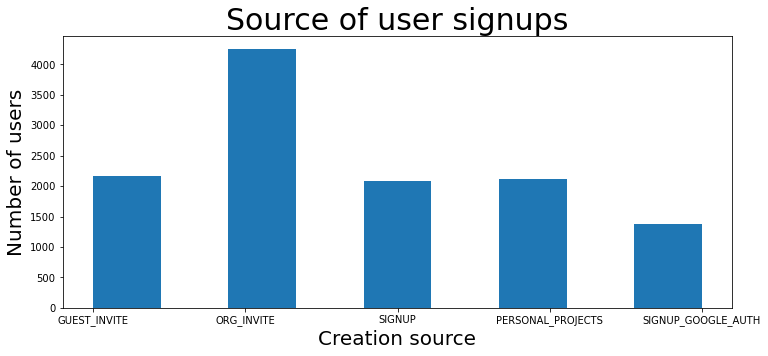

In [96]:
# get number of users for each creation source
print(df_user.groupby('creation_source')['object_id'].count())

#plt.rcParams["figure.figsize"] = (5,8)
plt.figure(figsize=(12, 5))

# Histogram of number of visits by individual users
plt.hist(df_user['creation_source'], bins=9)
plt.xlabel('Creation source', fontsize = 20)
plt.ylabel('Number of users', fontsize = 20)
plt.title('Source of user signups', fontsize = 30)

plt.show()

In [97]:
# Add email domain
df_user['domain'] = df_user['email'].apply(lambda x: x.split('@')[1])
print(df_user['domain'].value_counts().head(10))

# Create column of top six domains and 'other'
top_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df_user['domains'] = df_user['domain'].apply(lambda x: x if x in top_domains else 'other')

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
Name: domain, dtype: int64


**Summary:**
<br>24.9% of users opted into the mailing list and 14.9% enabled marketing. Organizational invite was the largets creation source. 

## Bring engagement data into user information table

In [98]:
#rename object_id as user_id to match df_engage
df_user = df_user.rename(columns={'object_id': 'user_id'})

In [99]:
# Add number of visits to user table
df_user = pd.merge(df_user, user_visits, on="user_id", how="left")


In [100]:
#create column of user ids in string format
df_user['id_str'] = df_user['user_id'].apply(str)

# add column with 1=adopted, 0=not adopted
df_user['adopted']= np.where(df_user['id_str'].isin(adopt_list_str), '1', '0')
df_user.sort_values(by=['visited'], ascending=False)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,domain,domains,visited,id_str,adopted
3622,3623,2012-06-25 14:34:33,Melo Vitória,VitoriaAlvesMelo@jourrapide.com,ORG_INVITE,1401201273,0,0,364,3623.0,jourrapide.com,jourrapide.com,606.0,3623,1
905,906,2012-06-17 22:49:52,Becker Jessika,JessikaBecker@gmail.com,SIGNUP_GOOGLE_AUTH,1401922192,0,0,358,NaN,gmail.com,gmail.com,600.0,906,1
1810,1811,2012-06-19 16:09:31,Carvalho Eduardo,EduardoCunhaCarvalho@gmail.com,SIGNUP_GOOGLE_AUTH,1400947771,1,1,33,NaN,gmail.com,gmail.com,593.0,1811,1
7589,7590,2012-06-08 00:51:13,Ferreira Rebeca,ffickuvv@qqgix.com,PERSONAL_PROJECTS,1401843073,0,0,225,NaN,qqgix.com,other,590.0,7590,1
8067,8068,2012-06-01 20:02:35,McCoy Donna,DonnaBMcCoy@hotmail.com,ORG_INVITE,1401393755,0,1,42,8068.0,hotmail.com,hotmail.com,585.0,8068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,11976,2013-12-25 22:01:41,Kohl Leah,LeahKohl@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,248,NaN,hotmail.com,hotmail.com,NaN,11976,0
11977,11978,2014-04-23 16:28:06,Castro Pedro,PedroCunhaCastro@gustr.com,PERSONAL_PROJECTS,NaN,1,0,29,NaN,gustr.com,gustr.com,NaN,11978,0
11984,11985,2013-07-08 17:23:26,Jespersen Marcus,MarcusTJespersen@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,74,NaN,cuvox.de,cuvox.de,NaN,11985,0
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN,cuvox.de,cuvox.de,NaN,11993,0


In [101]:
#check adopted column is correct
print(len(df_user[df_user['adopted']=='1']))


1602


# Modeling factors contributing to user adoption: linear regression

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Features for model:
 - **creation_source**: how their account was created. This takes on one of 5 values.
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
 - **creation_time**: when they created their account
 - **last_session_creation_time**: unix timestamp of last login
 - **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
 - **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
 - **org_id**: the organization (group of users) they belong to
 - **invited_by_user_id**: which user invited them to join (if applicable).

In [102]:
#reassign for modeling
df_model = df_user

In [103]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  domain                      12000 non-null  object        
 11  domains                     12000 non-null  object    

## Create dummies and clean missing data

In [104]:
# Binary column for invited_by_user_id
df_model['invited'] = df_model['invited_by_user_id'].fillna(0)
df_model['invited']= df_model['invited'].apply(lambda x: 0 if x == 0 else 1)
print(len(df_user[df_user['invited']==1]), ' users were invited to join')


6417  users were invited to join


In [105]:
# NaN to zero, float to int
df_model['last_session_creation_time'] = df_model['last_session_creation_time'].fillna(0)
df_model['visited'] = df_model['visited'].fillna(0)
df_model['visited'] = df_model['visited'].astype(int)

df_model['adopted'] = df_model['adopted'].fillna(0)
df_model['adopted'] = df_model['adopted'].astype(int)



In [106]:
# Get dummies for email domain
df_model = pd.get_dummies(df_model, columns=['domains'])
# Get dummies for Creation Source
df_model = pd.get_dummies(df_model, columns=['creation_source'])


In [107]:
#df_model.head()

In [108]:
df_model.describe()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,invited,domains_cuvox.de,domains_gmail.com,domains_gustr.com,domains_hotmail.com,domains_jourrapide.com,domains_other,domains_yahoo.com,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145,17.326417,0.133500,0.534750,0.100167,0.296833,0.098250,0.097083,0.104917,0.098833,0.203917,0.180250,0.354500,0.175917,0.173917,0.115417
std,3464.24595,0.432742,0.356432,124.056723,3383.761968,64.287839,0.340128,0.498812,0.300235,0.456881,0.297665,0.296084,0.306459,0.298451,0.402925,0.384412,0.478381,0.380765,0.379054,0.319537
min,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000,606.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
df_model.columns

Index(['user_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'domain',
       'visited', 'id_str', 'adopted', 'invited', 'domains_cuvox.de',
       'domains_gmail.com', 'domains_gustr.com', 'domains_hotmail.com',
       'domains_jourrapide.com', 'domains_other', 'domains_yahoo.com',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [110]:
# Drop fields not used
#df_model = df_model.drop(columns=['visited'])


## Linear regression model: full model

In [112]:
# Filter out fields not used: ids, timestamps, names, emails
#['user_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
#'id_str', 'org_id', 'invited_by_user_id'])
       
df_model = df_model[['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
       'adopted', 'visited','invited', 'domains_cuvox.de',
       'domains_gmail.com', 'domains_gustr.com', 'domains_hotmail.com',
       'domains_jourrapide.com', 'domains_other', 'domains_yahoo.com',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH']]



In [113]:
# train test split, 20% for testing, 80% for training
y = df_model.adopted
X = df_model.drop(['adopted'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=1)


In [114]:
# Steps, pipeline, scale, fit
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 1))]
pipeline = Pipeline(steps)
logreg_scaled = pipeline.fit(X_train, y_train)


In [115]:
# Model accuracy
print("The testing accuracy is "+"{:.1%}".format(logreg_scaled.score(X_test, y_test)))

The testing accuracy is 98.0%


In [116]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.97833333 0.97541667 0.98       0.98125    0.97541667]
Average 5-Fold CV Score: 0.9780833333333334


In [117]:
features = list(X)

In [118]:
# Check coefficients
logreg = LogisticRegression(random_state = 7)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
logreg.fit(X_train,y_train)
std_coef = logreg.coef_.reshape(-1,1).tolist()
feature_names = [feature.title() for feature in features]
coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
coef_df['abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
pd.set_option('display.max_rows', None)
print(coef_df)

                                        coef
Visited                             0.776079
Domains_Jourrapide.Com             -0.698423
Domains_Hotmail.Com                 0.546342
Domains_Gmail.Com                   0.505200
Domains_Other                      -0.358464
Domains_Yahoo.Com                  -0.249772
Opted_In_To_Mailing_List           -0.237673
Creation_Source_Signup              0.176338
Domains_Cuvox.De                    0.145594
Creation_Source_Signup_Google_Auth -0.144642
Creation_Source_Guest_Invite        0.141110
Domains_Gustr.Com                   0.109706
Creation_Source_Personal_Projects  -0.090573
Creation_Source_Org_Invite         -0.082051
Enabled_For_Marketing_Drip         -0.060008
Invited                             0.059059


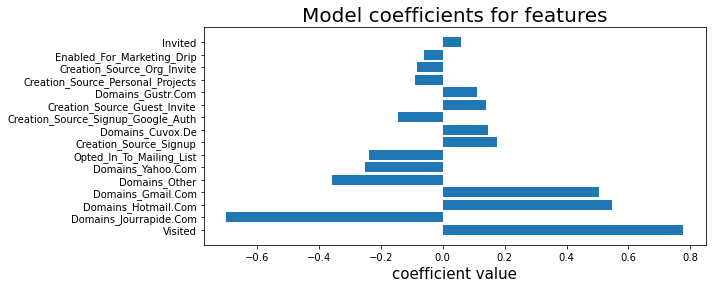

In [119]:
#reset index for plotting
coef_df = coef_df.reset_index()

# bar plot of feature coefficients
plt.barh(coef_df['index'],coef_df['coef'])
plt.xlabel('coefficient value', fontsize = 15)
plt.ylabel('', fontsize = 15)
plt.title('Model coefficients for features', fontsize = 20)

plt.show()

## Linear regression: remove 'visited'

In [120]:
# Filter out 'visited' feature. 
#This feature is directly related to the 'adopted'response and is not especially informative

       
df_model = df_model[['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
       'adopted', 'invited', 'domains_cuvox.de',
       'domains_gmail.com', 'domains_gustr.com', 'domains_hotmail.com',
       'domains_jourrapide.com', 'domains_other', 'domains_yahoo.com',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH']]



In [122]:
# train test split, 20% for testing, 80% for training
y = df_model.adopted
X = df_model.drop(['adopted'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=1)


In [123]:
# Steps, pipeline, scale, fit
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 1))]
pipeline = Pipeline(steps)
logreg_scaled = pipeline.fit(X_train, y_train)


In [124]:
# Model accuracy
print("The testing accuracy is "+"{:.1%}".format(logreg_scaled.score(X_test, y_test)))

The testing accuracy is 86.7%


In [125]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.86666667 0.86666667 0.86666667 0.86625    0.86625   ]
Average 5-Fold CV Score: 0.8664999999999999


In [126]:
features = list(X)

In [127]:
# Check coefficients
logreg = LogisticRegression(random_state = 7)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
logreg.fit(X_train,y_train)
std_coef = logreg.coef_.reshape(-1,1).tolist()
feature_names = [feature.title() for feature in features]
coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
coef_df['abs'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
pd.set_option('display.max_rows', None)
print(coef_df)

                                        coef
Creation_Source_Personal_Projects  -0.497104
Domains_Hotmail.Com                 0.305847
Creation_Source_Signup_Google_Auth  0.263242
Creation_Source_Guest_Invite        0.226408
Domains_Cuvox.De                   -0.173797
Domains_Yahoo.Com                  -0.170642
Invited                             0.134435
Domains_Gmail.Com                   0.119891
Creation_Source_Signup              0.099245
Creation_Source_Org_Invite         -0.091973
Domains_Gustr.Com                  -0.084387
Domains_Other                       0.044099
Domains_Jourrapide.Com             -0.041192
Opted_In_To_Mailing_List            0.019267
Enabled_For_Marketing_Drip         -0.011684


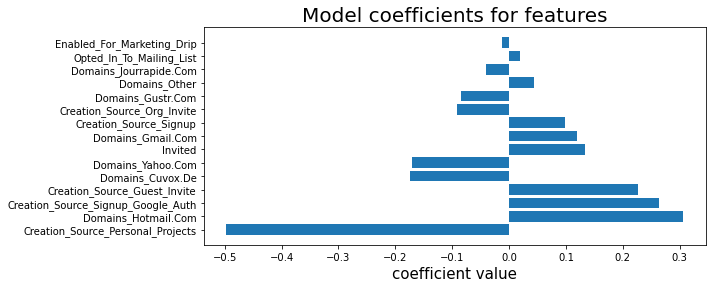

In [129]:
#reset index for plotting
coef_df = coef_df.reset_index()

# bar plot of feature coefficients
plt.barh(coef_df['index'],coef_df['coef'])
plt.xlabel('coefficient value', fontsize = 15)
plt.ylabel('', fontsize = 15)
plt.title('Model coefficients for features', fontsize = 20)

plt.show()

## Summary:
<br>Both models, with and without the number of user visits indicate simialar patters. The model with number of visits is 98% accurate, but this could be overfitting because number of visits is directly related to the definition of user adoption. The model was refit without the number of visits and though accuracy dropped, a similar pattern in feature influence was seen.
<br>Opting into the mailing list and being invited by another user are positively related to user adoption. Organization invite is negatively related to user adoption. The strongest negative indicator of adoption is users with personal project as their creation source.